## HW 2: State Estimation in Geothermal Heat Pump Drilling
Talia Arauzo
<br>2/22/21

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy import interp
from scipy import signal
%matplotlib inline
from __future__ import division
import pandas as pd
import control # Read http://python-control.sourceforge.net/manual/

fs = 15 # Font Size for plots

### Problem 2: Observability Analysis

In [2]:
# Drill String Parameters

J_T = 100  # Table/top rotational inertia
J_B = 25   # Bottom/bit rotational inertia
k = 2      # Spring constant
b = 5      # Drag coefficient

#### Part a

In [3]:
# State space matrices
A4 = np.matrix([[0, 0, 1, 0], [0, 0, 0, 1], [-k/J_T, k/J_T, -b/J_T, 0], [k/J_B, -k/J_B, 0, -b/J_B]])
B4 = np.matrix([[0, 0], [0, 0], [1/J_T, 0], [0, -1/J_B]])
C4 = np.matrix([[0, 0, 1, 0]])

# Compute observability Matrix for 4-state system and rank
O4 = control.obsv(A4, C4)
print('four-state system, rank(O) = ', np.linalg.matrix_rank(O4))
display(O4)

four-state system, rank(O) =  3


matrix([[ 0.      ,  0.      ,  1.      ,  0.      ],
        [-0.02    ,  0.02    , -0.05    ,  0.      ],
        [ 0.001   , -0.001   , -0.0175  ,  0.02    ],
        [ 0.00195 , -0.00195 ,  0.001875, -0.005   ]])

#### Part c

In [4]:
# New A Matrix, for 3-state system
A = np.matrix([[0, 1, -1], [-k/J_T, -b/J_T, 0], [k/J_B, 0, -b/J_B]])
B = np.matrix([[0, 0], [1/J_T, 0], [0, -1/J_B]])
C = np.matrix([[0, 1, 0]])

# Observability Matrix for 3-state system and rank
O = control.obsv(A, C)
print('three-state system, rank(O) = ', np.linalg.matrix_rank(O))
display(O)

three-state system, rank(O) =  3


matrix([[ 0.    ,  1.    ,  0.    ],
        [-0.02  , -0.05  ,  0.    ],
        [ 0.001 , -0.0175,  0.02  ]])

### Problem 3: Measurement Data

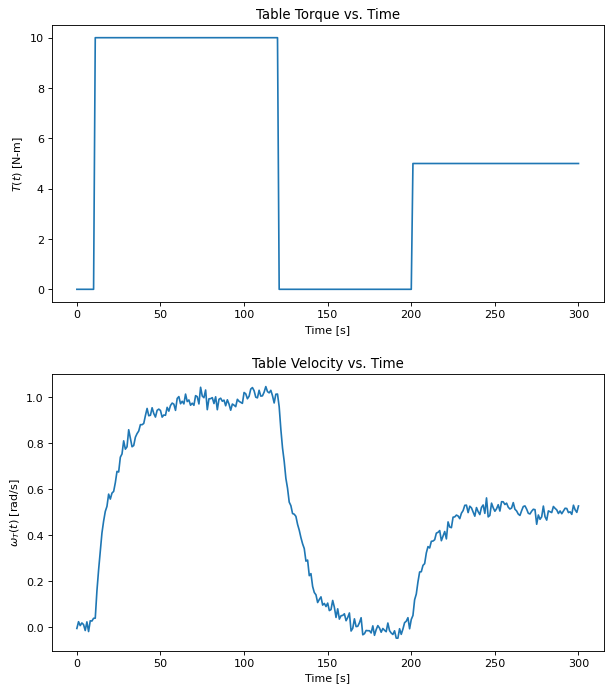

In [5]:
## Load Data
data=np.asarray(pd.read_csv("data/HW2_Data.csv",header=None))

t = data[:,0]      # t   : time vector [sec]
y_m = data[:,1]    # y_m : measured table velocity [radians/sec]
Torq = data[:,2]   # Torq: table torque [N-m]
omega_B_true = data[:,3]    # \omega_B : true rotational speed of bit [radians/sec]

# Plot Data
plt.figure(num=1, figsize=(8, 9), dpi=80, facecolor='w', edgecolor='k')

plt.subplot(2,1,1)
plt.plot(t, Torq)
plt.xlabel('Time [s]')
plt.ylabel('$T(t)$ [N-m]')
plt.title('Table Torque vs. Time')
# Plot table torque

plt.subplot(2,1,2)
plt.plot(t, y_m)
plt.xlabel('Time [s]')
plt.ylabel('$\omega_T(t)$ [rad/s]')
plt.title('Table Velocity vs. Time')
# Plot measured table velocity

plt.tight_layout(pad=2.0)
plt.show();

### Problem 4: Luenberger Observer

#### Part a

In [6]:
# Eigenvalues of open-loop system
lam_A, evec = np.linalg.eig(A)
print('Eigenvalues of open-loop system: ', lam_A)

Eigenvalues of open-loop system:  [-0.08338525+0.29860789j -0.08338525-0.29860789j -0.08322949+0.j        ]


#### Part b

In [46]:
# Desired poles of estimation error system
# They should have negative real parts
# Complex conjugate pairs
lam_luen = lam_A * 3

# Compute observer gain (See Remark 3.1 in Notes. Use "acker" command)
L = control.acker(A.T, C.T, lam_luen).T
print("Observer gain: ")
display(L)

Observer gain: 


matrix([[-39. ],
        [  0.5],
        [  0.6]])

#### Part c

In [47]:
# State-space Matrices for Luenberger Observer
A_lobs = A - (L*C)
B_lobs = np.hstack((B[:, 0], L))
C_lobs = C
D_lobs = np.matrix([0, 0])
display(A_lobs, B_lobs, C_lobs, D_lobs)

matrix([[ 0.0e+00,  4.0e+01, -1.0e+00],
        [-2.0e-02, -5.5e-01,  0.0e+00],
        [ 8.0e-02, -6.0e-01, -2.0e-01]])

matrix([[ 0.0e+00, -3.9e+01],
        [ 1.0e-02,  5.0e-01],
        [ 0.0e+00,  6.0e-01]])

matrix([[0, 1, 0]])

matrix([[0, 0]])

#### Part d

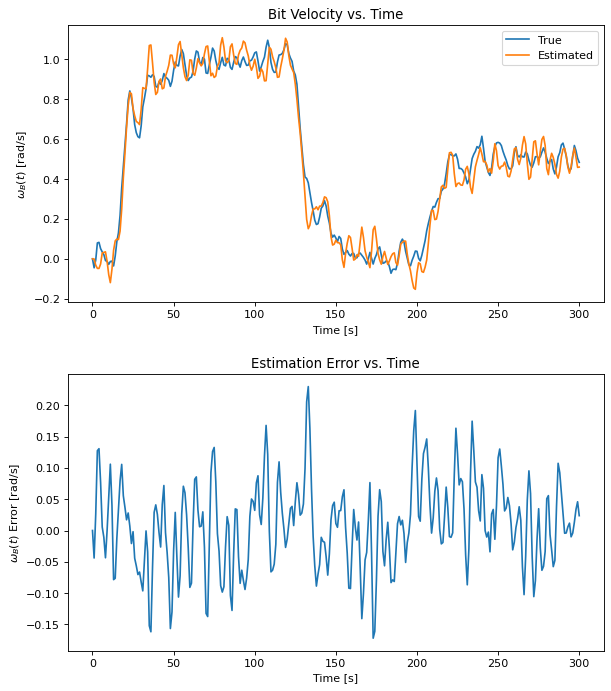

In [48]:
sys_lobs = signal.lti(A_lobs, B_lobs, C_lobs, D_lobs)

# Inputs to observer
u = np.array([Torq.T, y_m.T]).T

# Initial Conditions
x_hat0 = [0, 0, 0]

# Simulate Response
tsim, y, x_hat = signal.lsim(sys_lobs, U=u, T=t, X0=x_hat0)

# Parse states
theta_hat = x_hat[:,0]
omega_T_hat = x_hat[:,1]
omega_B_hat = x_hat[:,2]

# Plot Results
plt.figure(num=1, figsize=(8, 9), dpi=80, facecolor='w', edgecolor='k')

plt.subplot(2,1,1)
plt.plot(tsim, omega_B_true, label = 'True')
plt.plot(tsim, omega_B_hat, label = 'Estimated')
plt.xlabel('Time [s]')
plt.ylabel('$\omega_B(t)$ [rad/s]')
plt.title('Bit Velocity vs. Time')
plt.legend()
# Plot true and estimated bit velocity

plt.subplot(2,1,2)
plt.plot(tsim, omega_B_true - omega_B_hat)
plt.xlabel('Time [s]')
plt.ylabel('$\omega_B(t)$ Error [rad/s]')
plt.title('Estimation Error vs. Time')
# Plot error between true and estimated bit velocity

plt.tight_layout(pad=2.0)
plt.show();

In [49]:
# RMSE
T = tsim[-1]
error = omega_B_true - omega_B_hat
rmse = np.sqrt(np.sum(error**2)/T)
print('RMSE = ', rmse)

RMSE =  0.0698406480554874


### Problem 5: Kalman Filter Design

#### Part b

In [377]:
# Noise Covariances
W = np.matrix(np.eye(3) * 0.001) #You design this one. 
N = 0.02
Sig0 = np.identity(3)

# Initial Condition
x_hat0 = [0, 0, 0]
states0 = np.r_[x_hat0, np.squeeze(np.asarray(Sig0.reshape(9,1)))]

# Ordinary Differential Equation for Kalman Filter
def ode_kf(z,it):
    
    # Parse States
    x_hat = np.matrix(z[:3]).T
    Sig = np.matrix((z[3:]).reshape(3,3))
    
    # Interpolate input signal data
    iTorq = interp(it, t, Torq)
    iy_m = interp(it, t, y_m)
    
    # Compute Kalman Gain
    L = Sig * C.T * (1/N)
    
    # Kalman Filter
    u = iTorq.T
    y_hat = C * x_hat
    x_hat_dot = (A*x_hat) + (B[:, 0]*u) + (L*(iy_m - y_hat))
    
    # Riccati Equation
    Sig_dot = (Sig*A.T) + (A*Sig) + W - (Sig*C.T*(1/N)*C*Sig)
    
    # Concatenate LHS
    z_dot = np.r_[x_hat_dot, Sig_dot.reshape(9,1)]
    
    return(np.squeeze(np.asarray(z_dot)))


# Integrate Kalman Filter ODEs
z = odeint(ode_kf, states0, t)

# Parse States
theta_hat = z[:,0]
omega_T_hat = z[:,1]
omega_B_hat = z[:,2]
Sig33 = z[:, -1]   # Parse out the (3,3) element of Sigma only!

omega_B_tilde = omega_B_true - omega_B_hat
omega_B_hat_upperbound = omega_B_hat + np.sqrt(Sig33)
omega_B_hat_lowerbound = omega_B_hat - np.sqrt(Sig33)

RMSE = np.sqrt(np.mean(np.power(omega_B_tilde,2)))
print('Kalman Filter RMSE: ' + str(RMSE) + ' rad/s')

<ipython-input-377-47fc094d5487>:18: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  iTorq = interp(it, t, Torq)
<ipython-input-377-47fc094d5487>:19: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  iy_m = interp(it, t, y_m)


Kalman Filter RMSE: 0.052315082868877046 rad/s


#### Part c

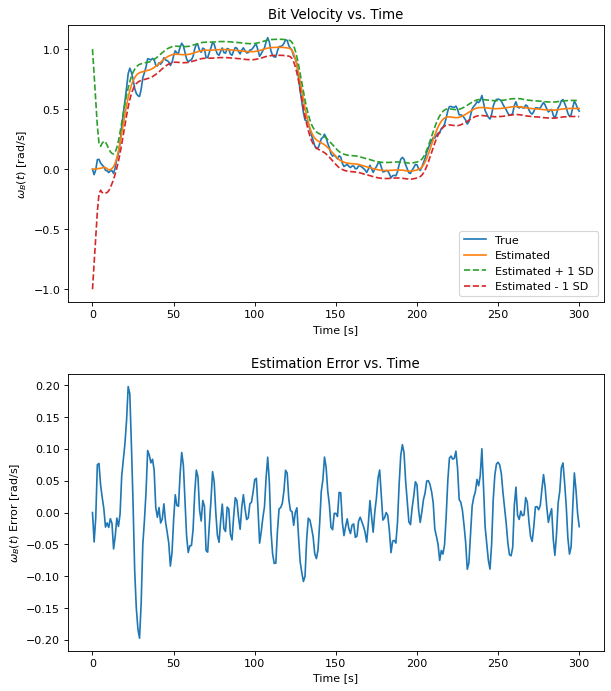

In [378]:
# Plot Results
plt.figure(num=3, figsize=(8, 9), dpi=80, facecolor='w', edgecolor='k')

plt.subplot(2,1,1)
plt.plot(t, omega_B_true, label = 'True')
plt.plot(t, omega_B_hat, label = 'Estimated')
plt.plot(t, omega_B_hat_upperbound, label = 'Estimated + 1 SD', linestyle = 'dashed')
plt.plot(t, omega_B_hat_lowerbound, label = 'Estimated - 1 SD', linestyle = 'dashed')
plt.xlabel('Time [s]')
plt.ylabel('$\omega_B(t)$ [rad/s]')
plt.title('Bit Velocity vs. Time')
plt.legend()
#   Plot true and estimated bit velocity
#   Plot estimated bit velocity plus/minus one sigma

plt.subplot(2,1,2)
plt.plot(tsim, omega_B_true - omega_B_hat)
plt.xlabel('Time [s]')
plt.ylabel('$\omega_B(t)$ Error [rad/s]')
plt.title('Estimation Error vs. Time')
#   Plot error between true and estimated bit velocity

plt.tight_layout(pad=2.0)
plt.show();

#### Part d

In [379]:
# Eigenvalues of A-L(t=300s)C
Sig_300 = z[-1, 3:].reshape((3, 3))
L_300 = Sig_300 * C.T * (1/N)
lam_kf, evec_kf = np.linalg.eig(A-(L_300*C))
print('Eigenvalues of A-L(t)C at t=300s: ', lam_kf)

Eigenvalues of A-L(t)C at t=300s:  [-0.09629086+0.29246942j -0.09629086-0.29246942j -0.21220948+0.j        ]


### Problem 6: Extended Kalman Filter Design

<ipython-input-380-70632f97bdb7>:24: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  iTorq = interp(it, t, Torq)
<ipython-input-380-70632f97bdb7>:25: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  iy_m = interp(it, t, y_m)


Extended Kalman Filter RMSE: 0.04657265247452875 rad/s


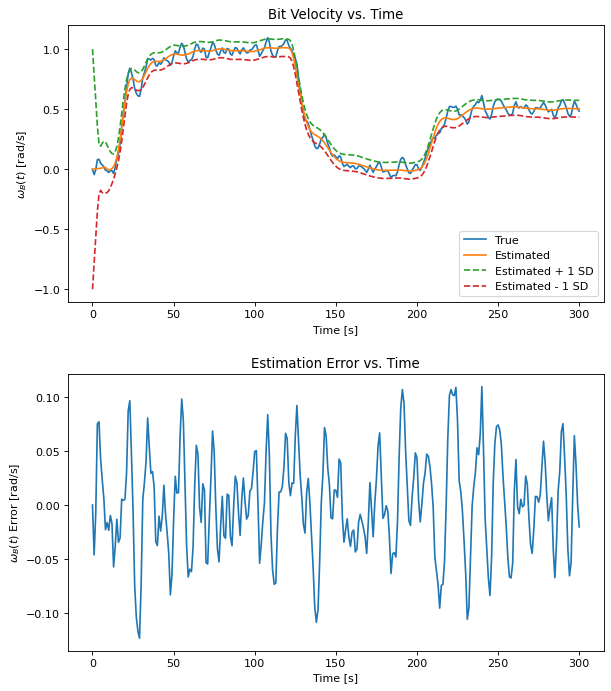

In [380]:
# New nonlinear spring parameters
k1 = 2
k2 = 0.25

# Noise Covariances
W = np.matrix(np.eye(3) * 0.001) #You design this one. 
N = 0.02
Sig0 = np.identity(3)

# Initial Condition
x_hat0 = [0, 0, 0]
states0 = np.r_[x_hat0, np.squeeze(np.asarray(Sig0.reshape(9,1)))]

# Ordinary Differential Equation for Kalman Filter
def ode_ekf(z,it):
    
    # Parse States
    theta_hat = z[0]
    omega_T_hat = z[1]
    omega_B_hat = z[2]
    Sig = np.matrix((z[3:]).reshape(3,3))
    
    # Interpolate input signal data
    iTorq = interp(it, t, Torq)
    iy_m = interp(it, t, y_m)
    
    # Compute Jacobians
    F = np.matrix([[0, 1, -1],
                   [(-k1/J_T)-((3*k2/J_T)*(theta_hat**2)), -b/J_T, 0],
                   [(k1/J_B)+((3*k2/J_B)*(theta_hat**2)), 0, -b/J_B]])
    H = C
    
    # Compute Kalman Gain
    L = Sig * H.T * (1/N)
    
    # Compute EKF system matrices
    y_hat = omega_T_hat
    
    theta_hat_dot = omega_T_hat - omega_B_hat + (L[0]*(iy_m-y_hat))
    omega_T_hat_dot = ((-k1/J_T)*theta_hat) - ((k2/J_T)*(theta_hat**3)) - ((b/J_T)*omega_T_hat) + ((1/J_T)*iTorq) + (L[1]*(iy_m-y_hat))
    omega_B_hat_dot = ((k1/J_B)*theta_hat) + ((k2/J_B)*(theta_hat**3)) - ((b/J_B)*omega_B_hat) + (L[2]*(iy_m-y_hat))
    
    # Riccati Equation
    Sig_dot = (Sig*F.T) + (F*Sig) + W - (Sig*H.T*(1/N)*H*Sig)
    
    # Concatenate LHS
    z_dot = np.r_[theta_hat_dot, omega_T_hat_dot, omega_B_hat_dot, Sig_dot.reshape(9,1)]
    
    return(np.squeeze(np.asarray(z_dot)))


# Integrate Extended Kalman Filter ODEs
z = odeint(ode_ekf, states0, t)

# Parse States
theta_hat = z[:,0]
omega_T_hat = z[:,1]
omega_B_hat = z[:,2]
Sig33 = z[:, -1]    # Parse out the (3,3) element of Sigma only!

omega_B_tilde = omega_B_true - omega_B_hat
omega_B_hat_upperbound = omega_B_hat + np.sqrt(Sig33)
omega_B_hat_lowerbound = omega_B_hat - np.sqrt(Sig33)

RMSE = np.sqrt(np.mean(np.power(omega_B_tilde,2)))
print('Extended Kalman Filter RMSE: ' + str(RMSE) + ' rad/s')

# Plot Results
plt.figure(num=3, figsize=(8, 9), dpi=80, facecolor='w', edgecolor='k')

plt.subplot(2,1,1)
plt.plot(t, omega_B_true, label = 'True')
plt.plot(t, omega_B_hat, label = 'Estimated')
plt.plot(t, omega_B_hat_upperbound, label = 'Estimated + 1 SD', linestyle = 'dashed')
plt.plot(t, omega_B_hat_lowerbound, label = 'Estimated - 1 SD', linestyle = 'dashed')
plt.xlabel('Time [s]')
plt.ylabel('$\omega_B(t)$ [rad/s]')
plt.title('Bit Velocity vs. Time')
plt.legend()
#   Plot true and estimated bit velocity
#   Plot estimated bit velocity plus/minus one sigma

plt.subplot(2,1,2)
plt.plot(tsim, omega_B_true - omega_B_hat)
plt.xlabel('Time [s]')
plt.ylabel('$\omega_B(t)$ Error [rad/s]')
plt.title('Estimation Error vs. Time')
#   Plot error between true and estimated bit velocity

plt.tight_layout(pad=2.0)
plt.show();